In [1]:
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

In [3]:
class INRIA_VOC_Dataset(Dataset):
    def __init__(self, ann_dir, img_dir, transforms=None):
        self.ann_dir = ann_dir
        self.img_dir = img_dir
        self.transforms = transforms
        self.ann_files = sorted([f for f in os.listdir(ann_dir) if f.endswith('.xml')])

    def __getitem__(self, idx):
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        tree = ET.parse(ann_path)
        root = tree.getroot()

        filename = root.find('filename').text
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            if name.lower() != 'person':
                continue
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # label 1: person

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ann_files)


In [5]:
transform = T.ToTensor()

dataset = INRIA_VOC_Dataset(
    ann_dir="/kaggle/input/inriaperson/Train/Annotations",
    img_dir="/kaggle/input/inriaperson/Train/JPEGImages",
    transforms=transform
)

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

print(f"Dataset có {len(dataset)} ảnh.")


Dataset có 614 ảnh.


In [6]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

def get_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes=2)  # background + person
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 5
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
    
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "/kaggle/working/fasterrcnn_inria.pth")
print("Đã lưu model tại /kaggle/working/fasterrcnn_inria.pth")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 186MB/s]  


[Epoch 1] Loss: 50.1618
[Epoch 2] Loss: 32.5907
[Epoch 3] Loss: 27.5974
[Epoch 4] Loss: 23.2671
[Epoch 5] Loss: 20.5264
Đã lưu model tại /kaggle/working/fasterrcnn_inria.pth


In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_model(num_classes=2)  # như lúc train
model.load_state_dict(torch.load("/kaggle/working/fasterrcnn_inria.pth", map_location=device))
model.to(device)
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
from PIL import Image
import torchvision.transforms as T

img_path = "/kaggle/input/inriaperson/Test/JPEGImages/crop001634.png"
image = Image.open(img_path).convert("RGB")

transform = T.Compose([T.ToTensor()])
img_tensor = transform(image).to(device)


In [10]:
with torch.no_grad():
    prediction = model([img_tensor])  # đầu vào là list ảnh
pred = prediction[0]
boxes = pred['boxes']          # Tensor Nx4, tọa độ bbox
labels = pred['labels']        # Tensor N
scores = pred['scores']        # Tensor N


In [11]:
threshold = 0.5
keep = scores >= threshold

boxes = boxes[keep].cpu().numpy()
labels = labels[keep].cpu().numpy()
scores = scores[keep].cpu().numpy()


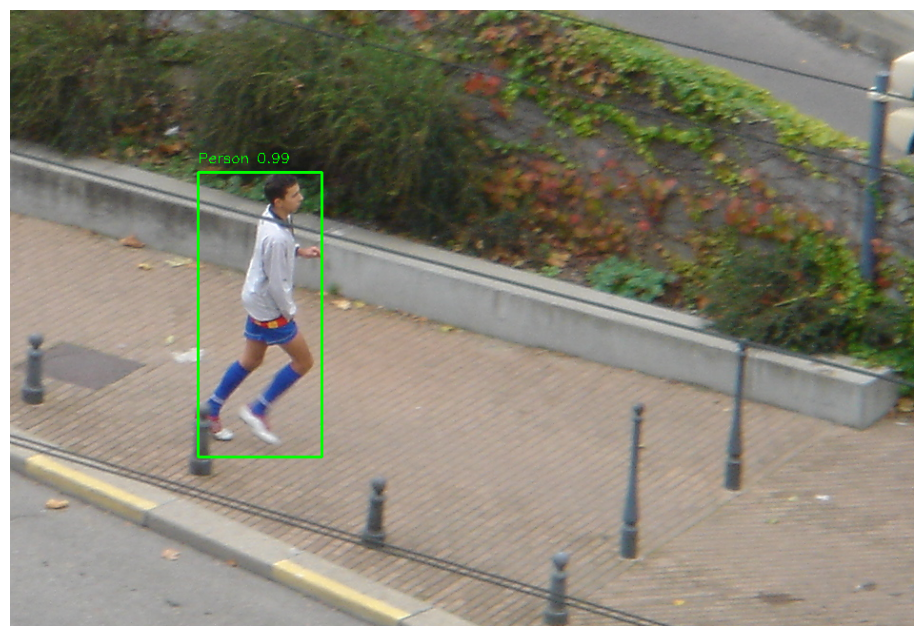

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_cv = np.array(image)[:, :, ::-1].copy()  # PIL RGB → BGR OpenCV

for box, score in zip(boxes, scores):
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img_cv, f"Person {score:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [13]:
import torchvision
import torchvision.transforms as T
import torch
import cv2
from tqdm import tqdm
import numpy as np

# Hàm khởi tạo mô hình Faster R-CNN với 2 lớp: background + person
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

# Load mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2)
model.load_state_dict(torch.load("/kaggle/working/fasterrcnn_inria.pth", map_location=device))
model.to(device)
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
transform = T.Compose([T.ToTensor()])

video_path = '/kaggle/input/baminton/badminton2.mp4'
output_video_path = '/kaggle/working/output_video.mp4'

cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

for _ in tqdm(range(frame_count), desc="Processing frames"):
    ret, frame = cap.read()
    if not ret:
        break

    # Tiền xử lý
    img_tensor = transform(frame).to(device)

    with torch.no_grad():
        prediction = model([img_tensor])[0]

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    # Chọn các box có độ tin cậy > 0.5
    filtered = [(box, score) for box, score in zip(boxes, scores) if score > 0.5]

    # Lấy 2 box lớn nhất
    if len(filtered) > 0:
        filtered = sorted(filtered, key=lambda x: (x[0][2]-x[0][0]) * (x[0][3]-x[0][1]), reverse=True)[:2]
        for box, score in filtered:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    out.write(frame)

cap.release()
out.release()
print(f"✅ Video đã lưu tại: {output_video_path}")


Processing frames: 100%|██████████| 2079/2079 [04:58<00:00,  6.97it/s]

✅ Video đã lưu tại: /kaggle/working/output_video_test.mp4


In [15]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google

In [16]:
import cv2
import mediapipe as mp
import pandas as pd

# MediaPipe khởi tạo
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Đường dẫn file
input_path = '/kaggle/working/output_video.mp4'  # Thay bằng thư mục bạn đã upload
output_video_path = '/kaggle/working/foot_landmarks_video.mp4'
output_csv_path = '/kaggle/working/foot_positions.csv'

# Mở video
cap = cv2.VideoCapture(input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Ghi video đầu ra
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Data cho CSV
all_data = []
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(img_rgb)

    landmarks_list = []

    if results.pose_landmarks:
        # Trong video có sẵn 2 người, giả định MediaPipe detect được cả 2.

        # Giả định MediaPipe chỉ trả về 1 người => bạn cần tự thêm bước detect 2 người nếu cần thiết
        # Ở đây tạm coi bạn đã có logic để có danh sách 2 người trong landmarks_list
        # Tạm thời chỉ xử lý 1 người: bạn có thể mở rộng sau
        landmarks = results.pose_landmarks.landmark

        # Lấy gót chân trái/phải
        left_heel = landmarks[mp_pose.PoseLandmark.LEFT_HEEL]
        right_heel = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL]

        l_heel = (int(left_heel.x * width), int(left_heel.y * height))
        r_heel = (int(right_heel.x * width), int(right_heel.y * height))

        landmarks_list.append({'left_heel': l_heel, 'right_heel': r_heel})

    # Gán player1, player2 theo vị trí trái/phải
    def get_avg_x(lm):  # trung bình x để biết bên trái hay phải
        return (lm['left_heel'][0] + lm['right_heel'][0]) / 2

    sorted_players = sorted(landmarks_list, key=get_avg_x)

    for i, player in enumerate(sorted_players):
        player_id = f'player{i+1}'

        lx, ly = player['left_heel']
        rx, ry = player['right_heel']

        # Vẽ lên khung hình
        cv2.circle(frame, (lx, ly), 8, (255, 0, 0), -1)
        cv2.circle(frame, (rx, ry), 8, (0, 255, 0), -1)
        cv2.putText(frame, player_id, (int((lx+rx)/2), int((ly+ry)/2)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        all_data.append({
            'frame': frame_idx,
            'player': player_id,
            'left_heel_x': lx,
            'left_heel_y': ly,
            'right_heel_x': rx,
            'right_heel_y': ry
        })

    out.write(frame)
    frame_idx += 1

# Lưu CSV
df = pd.DataFrame(all_data)
df.to_csv(output_csv_path, index=False)

# Đóng video
cap.release()
out.release()
pose.close()

2025-05-16 01:50:04.754032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747360205.260607      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747360205.397691      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747360221.644855     129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747360221.701809     129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:17473

In [86]:
import cv2 as cv 
import numpy as np

cap = cv.VideoCapture("/kaggle/working/output_video.mp4")
cap.set(cv.CAP_PROP_POS_FRAMES, 1000)
ret, frame = cap.read()
cap.release()

img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)


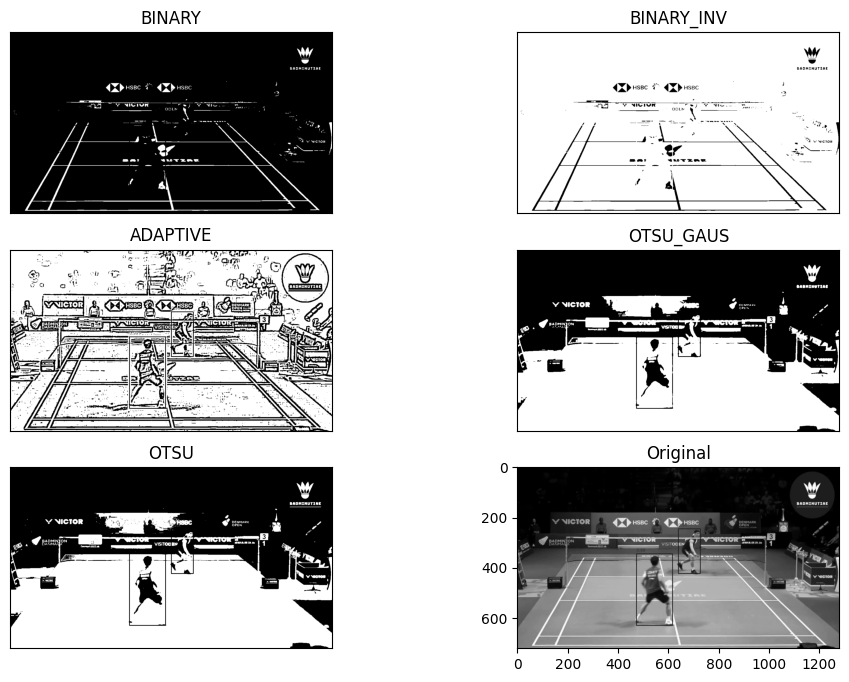

In [87]:
# Testing different Image Binarizations

from matplotlib import pyplot as plt

ret,th1 = cv.threshold(img,190,255,cv.THRESH_BINARY) 
ret,th2 = cv.threshold(img,190,255,cv.THRESH_BINARY_INV)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)  

blur = cv.GaussianBlur(img,(5,5),0)
ret,th4 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU) 

ret,th5 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU) 

images = [th1,th2,th3,th4, th5] 
titles = ['BINARY', 'BINARY_INV', 'ADAPTIVE', 'OTSU_GAUS', 'OTSU'] 


plt.figure(figsize=(12,8))
for i in range(5): 
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i],'gray') 
    plt.title(titles[i]) 
    plt.xticks([]),plt.yticks([])

plt.subplot(3,2,6)
plt.imshow(img, 'gray') 
plt.title('Original')
plt.show() 

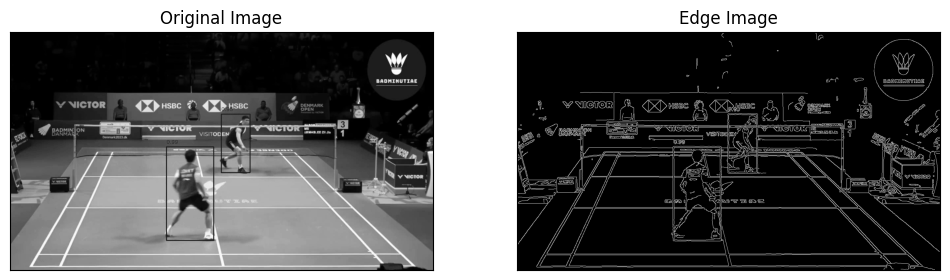

In [88]:
import numpy as np

# Visualizing edges

v = np.median(img)
sigma = 0.33 

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v)) 
upper = int(min(255, (1.0 + sigma) * v)) 
edges = cv.Canny(img, lower, upper, apertureSize=3) 

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

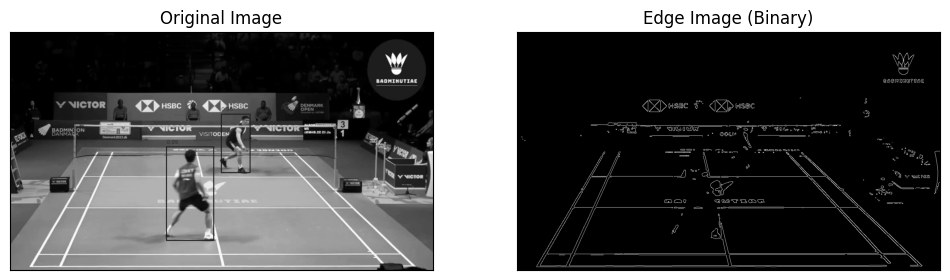

In [89]:
# Visualizing edges for binarized image 

v = np.median(img)
sigma = 0.33

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v)) 
upper = int(min(255, (1.0 + sigma) * v)) 
edges = cv.Canny(th1, lower, upper, apertureSize=3) 

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image (Binary)'), plt.xticks([]), plt.yticks([])
plt.show()

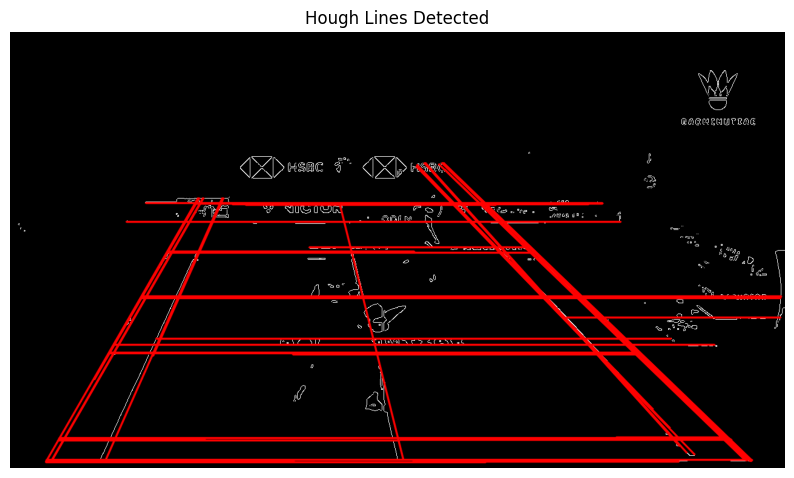

In [90]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Giả sử bạn đã có ảnh edges từ Canny trước đó
# edges = cv.Canny(...)

# Chuyển ảnh edges sang BGR để vẽ đường màu lên
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

# Probabilistic Hough Transform
linesP = cv.HoughLinesP(edges, 1, np.pi / 90, 90, None, 10, 250)

if linesP is not None:
    for i in range(len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 2, cv.LINE_AA)

# Hiển thị ảnh kết quả trong notebook (KHÔNG lưu, KHÔNG dùng imshow)
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(cdstP, cv.COLOR_BGR2RGB))  # Chuyển từ BGR sang RGB cho đúng màu
plt.title('Hough Lines Detected')
plt.axis('off')
plt.show()



In [91]:
def segment_lines(lines, deltaX, deltaY):
    h_lines = []
    v_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if abs(y2-y1) < deltaY: # y-values are near; line is horizontal
                h_lines.append(line)
            elif abs(x2-x1) < deltaX: # x-values are near; line is vertical
                v_lines.append(line)
    return h_lines, v_lines
h_lines, v_lines = segment_lines(linesP, 500, 0.5) 
print('Total number of lines: ', linesP.shape[0]) 
print('Number of horizontal lines: ', len(h_lines)) 
print('Number of vertical lines: ', len(v_lines))  


Total number of lines:  45
Number of horizontal lines:  27
Number of vertical lines:  14


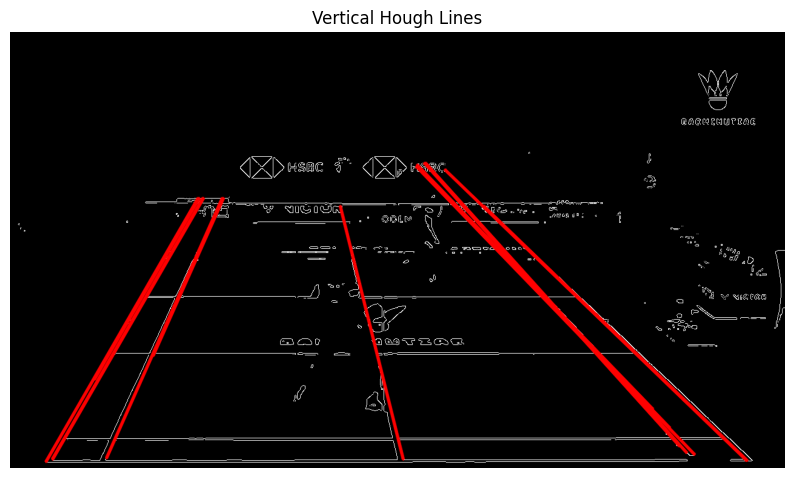

In [92]:
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

# Drawing Vertical Hough Lines on image
for i in range(len(v_lines)):
    l = v_lines[i][0]
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

# Dùng matplotlib để hiển thị (KHÔNG dùng imshow/waitKey)
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(cdstP, cv.COLOR_BGR2RGB))  # Đổi màu BGR -> RGB
plt.title('Vertical Hough Lines')
plt.axis('off')
plt.show()


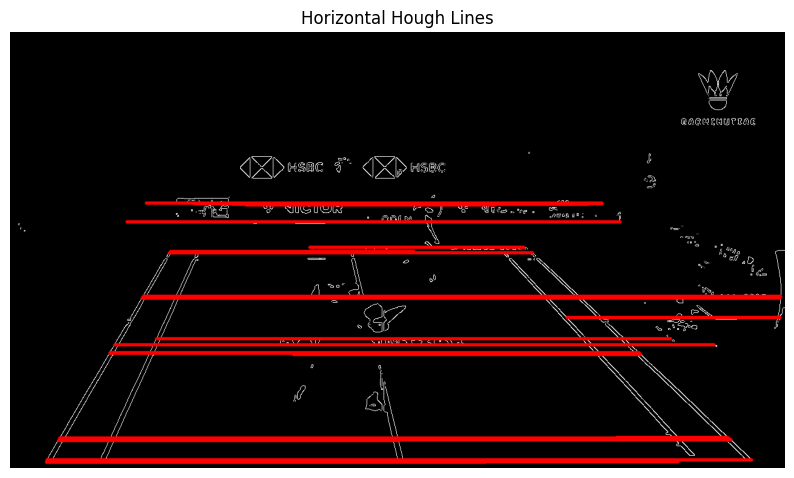

In [93]:
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

# Vẽ các đường ngang
for i in range(len(h_lines)):
    l = h_lines[i][0]
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv.LINE_AA)

# Hiển thị bằng matplotlib (đúng màu)
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(cdstP, cv.COLOR_BGR2RGB))  # chuyển sang RGB để hiển thị
plt.title('Horizontal Hough Lines')
plt.axis('off')
plt.show()


In [94]:
def filterLines(segments, minLength, maxLength): 
    result = []
    for segment in segments: 
        for x1,y1,x2,y2 in segment:  
            length = math.dist([x1,y1], [x2,y2])
            print("Length:", length)  # In tất cả chiều dài để debug
            if minLength < length < maxLength: 
                print(x1,y1, '\t', x2,y2, '\t', length)
                result.append(segment) 
        print('------------------------------')
    return result  

Length: 1165.0
60 706 	 1225 706 	 1165.0
------------------------------
Length: 1106.0
81 670 	 1187 670 	 1106.0
------------------------------
Length: 726.0
59 710 	 785 710 	 726.0
------------------------------
Length: 876.0
164 530 	 1040 530 	 876.0
------------------------------
Length: 547.0
644 673 	 1191 673 	 547.0
------------------------------
Length: 754.0
224 282 	 978 282 	 754.0
------------------------------
Length: 409.0
60 707 	 469 707 	 409.0
------------------------------
Length: 439.0
665 709 	 1104 709 	 439.0
------------------------------
Length: 564.0
79 674 	 643 674 	 564.0
------------------------------
Length: 1054.0
219 436 	 1273 436 	 1054.0
------------------------------
Length: 802.0
471 437 	 1273 437 	 802.0
------------------------------
Length: 674.0
304 283 	 978 283 	 674.0
------------------------------
Length: 816.0
192 313 	 1008 313 	 816.0
------------------------------
Length: 875.0
164 529 	 1039 529 	 875.0
---------------------------

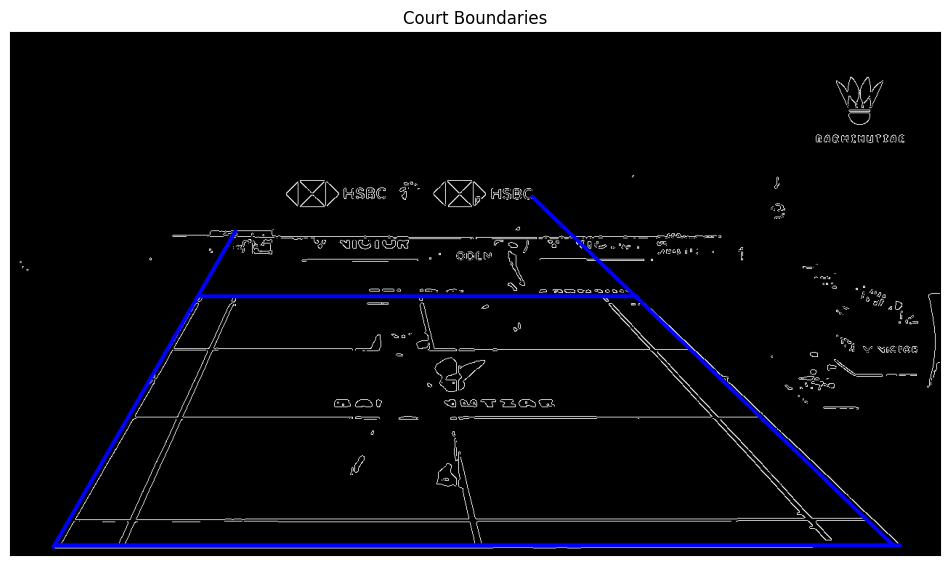

In [187]:
def getCourtLines(hsegments, vsegments): 
    h_result = [] 
    v_result = [] 
    for segment in hsegments: 
        for x1,y1,x2,y2 in segment:
            # Identified horizontal boundary lines using Brute Force
            if  (600.0 < math.dist([x1,y1] , [x2,y2]) < 602.0) or  (1110 < math.dist([x1,y1] , [x2,y2]) < 1200.0): 
                h_result.append(segment)
                
    for segment in vsegments: 
        for x1,y1,x2,y2 in segment:
            # Identified vertical boundary lines using Brute Force
            if  (500.0 < math.dist([x1,y1] , [x2,y2]) < 510.0) or  (691 < math.dist([x1,y1] , [x2,y2]) < 692):
                v_result.append(segment)   

    return h_result, v_result
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR) 

filtered_h_lines, filtered_v_lines = getCourtLines(filterLines(h_lines,400, 1200), filterLines(v_lines,500, 700))

print('Filtered Vertical Lines: ', len(filtered_v_lines))
print('Filtered Horizontal Lines: ', len(filtered_h_lines))

# Drawing Vertical Hough Lines on image 
for i in range(len(filtered_v_lines)): 
    l = filtered_v_lines[i][0] 
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)  
    
# Drawing Horizontal Hough Lines on image 
for i in range(len(filtered_h_lines)): 
    l = filtered_h_lines[i][0] 
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)  
    
plt.figure(figsize=(12,8)) 
plt.imshow(cdstP, cmap='Reds') 
plt.title('Court Boundaries'), plt.xticks([]), plt.yticks([])
plt.show() 

In [188]:
def find_intersection(line1, line2):
    # extract points
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    # compute determinant
    Px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4))/  \
        ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
    Py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4))/  \
        ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
    
    return Px, Py
def cluster_points(points, nclusters):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, _, centers = cv.kmeans(points, nclusters, None, criteria, 10, cv.KMEANS_PP_CENTERS)
    return centers 
# find the line intersection points
Px = []
Py = []
for h_line in filtered_h_lines:
    for v_line in filtered_v_lines:
        px, py = find_intersection(h_line, v_line)
        Px.append(px)
        Py.append(py)
print(Px)
print(Py)

[1214.9625, 60.73103448275862, 860.1375, 258.0689655172414]
[706.0, 706.0, 364.0, 364.0]


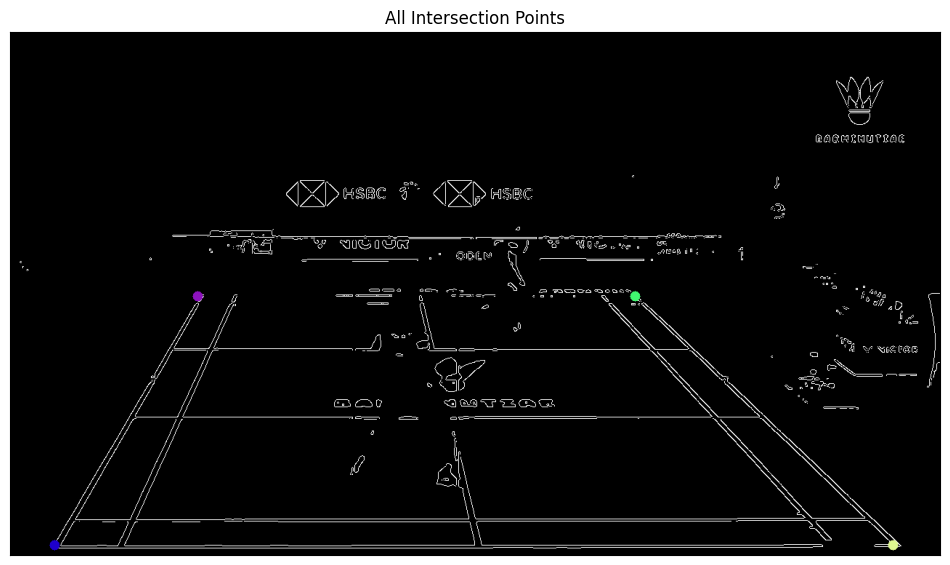

In [189]:
# draw the intersection points (all of them) 

intersectsimg = edges.copy()
intersectsimg = cv.cvtColor(intersectsimg, cv.COLOR_GRAY2BGR) 

for cx, cy in zip(Px, Py):
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    color = np.random.randint(0,255,3).tolist() # random colors
    cv.circle(intersectsimg, (cx, cy), radius=7, color=color, thickness=-1) # -1: filled circle

plt.figure(figsize=(12,8)) 
plt.imshow(intersectsimg, cmap='magma') 
plt.title('All Intersection Points'), plt.xticks([]), plt.yticks([])
plt.show() 

In [190]:
# use clustering to find the centers of the data clusters

# P is the set of all the (x,y) of all the intersection points. This is done through column_stack
P = np.float32(np.column_stack((Px, Py)))
nclusters = 4
centers = cluster_points(P, nclusters)
print(centers)

[[ 860.1375    364.      ]
 [  60.731033  706.      ]
 [1214.9625    706.      ]
 [ 258.06897   364.      ]]


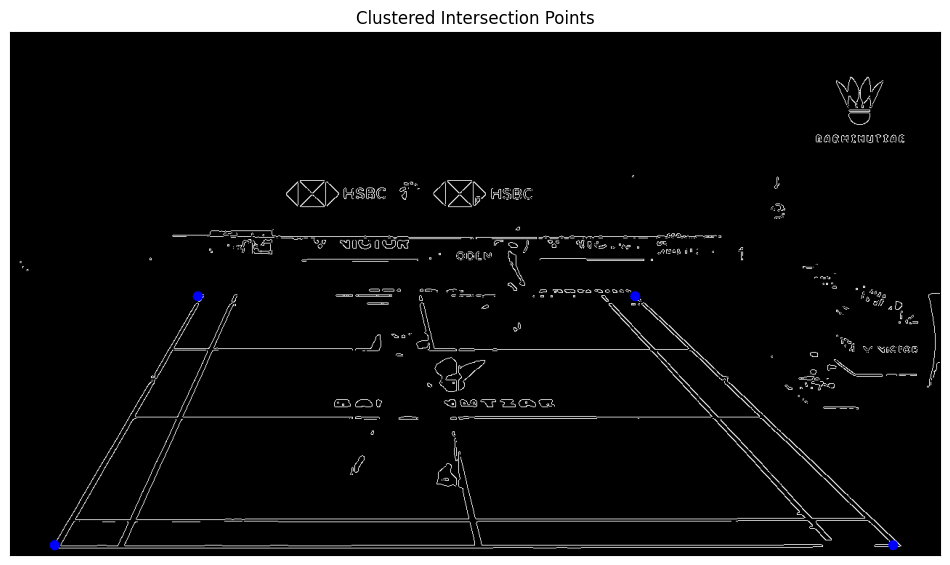

In [191]:
# draw the center of the clusters

intersectsimg = edges.copy()
intersectsimg = cv.cvtColor(intersectsimg, cv.COLOR_GRAY2BGR)

for cx, cy in centers:
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    cv.circle(intersectsimg, (cx, cy), radius=7, color=[0,0,255], thickness=-1) # -1: filled circle
    
plt.figure(figsize=(12,8)) 
plt.imshow(intersectsimg, cmap='magma') 
plt.title('Clustered Intersection Points'), plt.xticks([]), plt.yticks([])
plt.show() 

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Load dữ liệu CSV từ bước trước
df = pd.read_csv('/kaggle/working/foot_positions.csv')
# Các điểm homography: image (pixel) -> court (cm)
image_pts = np.array([
    [258, 364],  # Top-left
    [860, 364],  # Top-right
    [60, 706],  # Bottom-left
    [1214, 706], # Bottom-right
], dtype=np.float32)
court_pts = np.array([[0, 0], [610, 0], [0, 1340], [610, 1340]], dtype=np.float32)

H, _ = cv2.findHomography(image_pts, court_pts)

def apply_homography(x, y):
    pts = np.array([[x, y]], dtype='float32')
    pts = np.array([pts])
    dst = cv2.perspectiveTransform(pts, H)
    return dst[0][0]

# Tính vị trí trung bình gót chân → chuyển đổi
df['foot_x'] = (df['left_heel_x'] + df['right_heel_x']) / 2
df['foot_y'] = (df['left_heel_y'] + df['right_heel_y']) / 2

court_coords = df[['foot_x', 'foot_y']].apply(lambda row: apply_homography(row['foot_x'], row['foot_y']), axis=1)
df[['court_x', 'court_y']] = pd.DataFrame(court_coords.tolist(), index=df.index)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


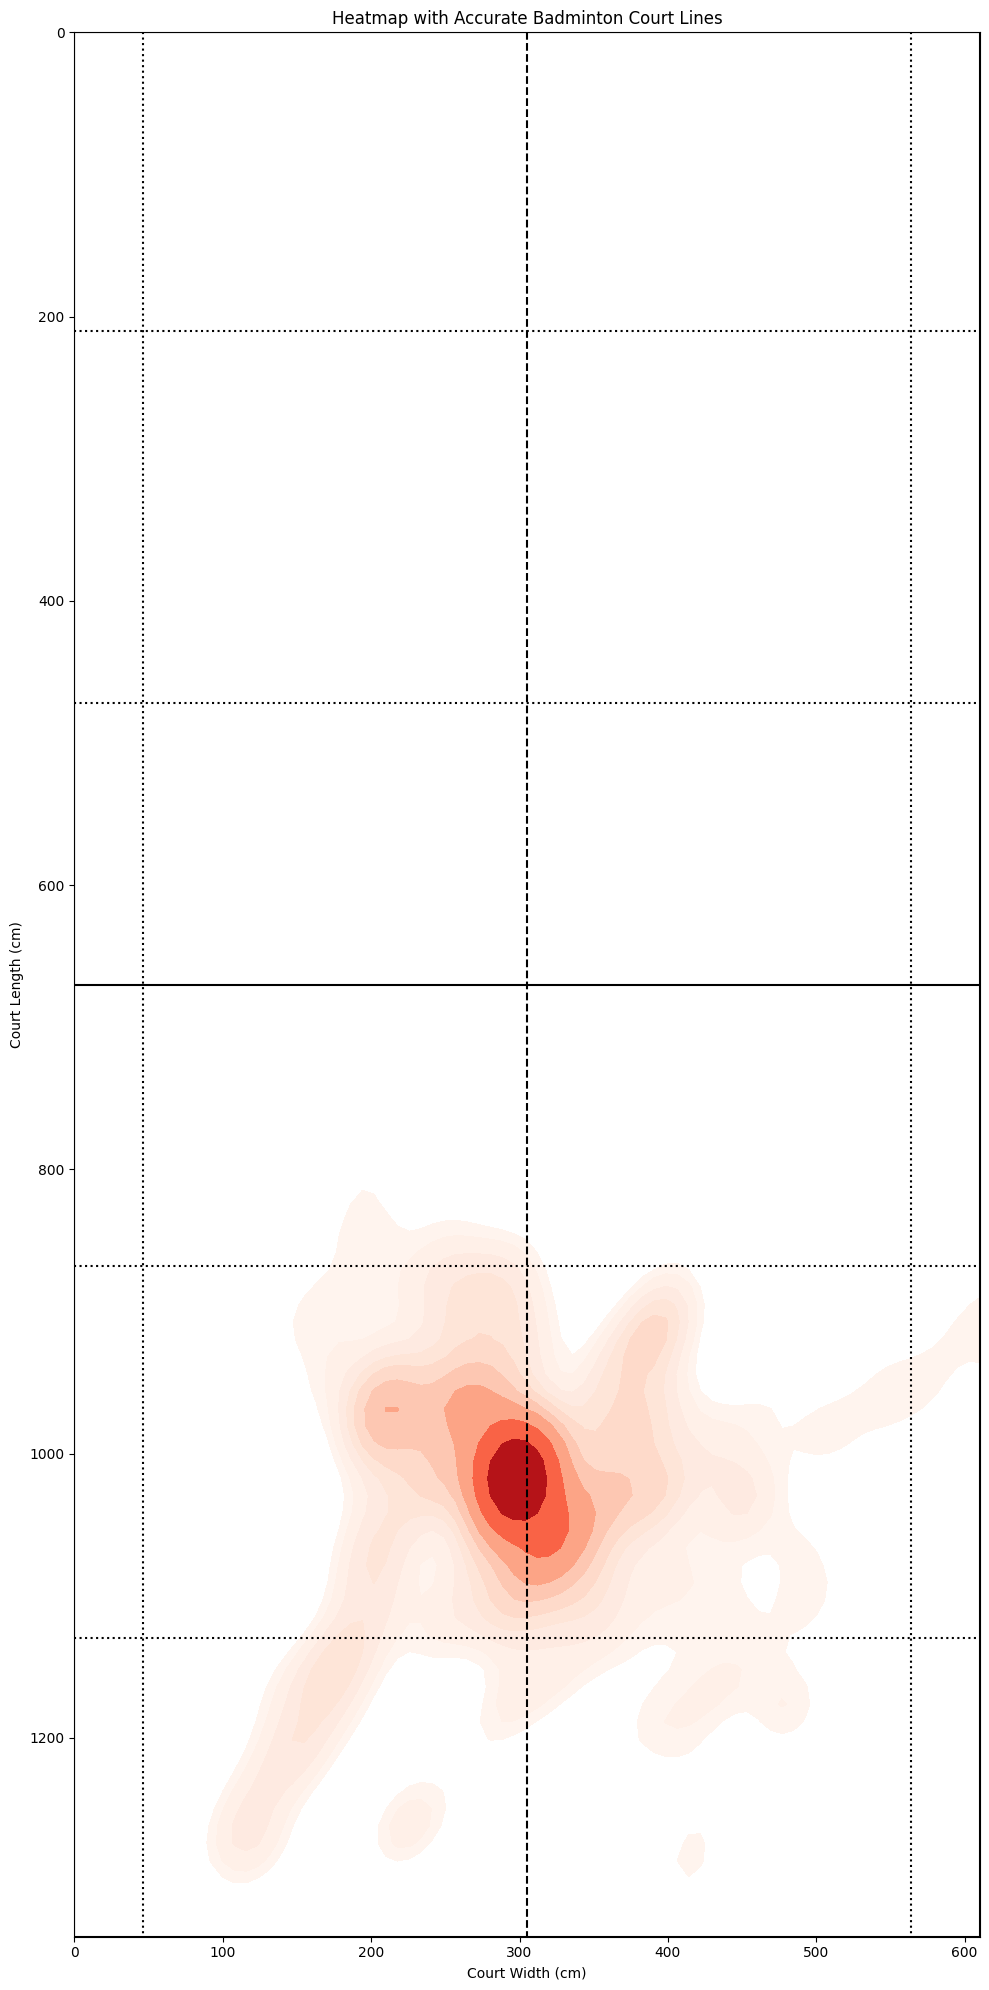

In [193]:
plt.figure(figsize=(10, 20))

# Vẽ heatmap
sns.kdeplot(
    data=df, x='court_x', y='court_y',
    fill=True, cmap='Reds', bw_adjust=0.6, thresh=0.1
)


# Vẽ các đường sân cầu lông
court_w = 610
court_l = 1340

# Đường bao sân (đánh đôi)
plt.plot([0, court_w], [0, 0], 'k')  # biên ngang dưới
plt.plot([0, court_w], [court_l, court_l], 'k')  # biên ngang trên
plt.plot([0, 0], [0, court_l], 'k')  # biên dọc trái
plt.plot([court_w, court_w], [0, court_l], 'k')  # biên dọc phải

# Vạch giữa sân (từ lưới)
center_x = court_w / 2
plt.plot([center_x, center_x], [0, court_l], 'k', linestyle='--')

# Lưới ở giữa sân
net_y = court_l / 2
plt.plot([0, court_w], [net_y, net_y], 'k')

# Đường phát cầu ngắn (cách lưới 198 cm mỗi bên)
plt.plot([0, court_w], [net_y - 198, net_y - 198], 'k', linestyle=':')
plt.plot([0, court_w], [net_y + 198, net_y + 198], 'k', linestyle=':')

# Đường phát cầu dài cho đôi (cách biên ngang 210 cm mỗi bên)
plt.plot([0, court_w], [court_l - 210, court_l - 210], 'k', linestyle=':')
plt.plot([0, court_w], [210, 210], 'k', linestyle=':')

# Biên đơn (chỉ cần nếu bạn phân biệt đánh đơn và đôi)
single_sideline_left = (court_w - 518) / 2
single_sideline_right = court_w - single_sideline_left
plt.plot([single_sideline_left, single_sideline_left], [0, court_l], 'k', linestyle=':')
plt.plot([single_sideline_right, single_sideline_right], [0, court_l], 'k', linestyle=':')

# Hiển thị
plt.title('Heatmap with Accurate Badminton Court Lines')
plt.xlim(0, court_w)
plt.ylim(0, court_l)
plt.gca().invert_yaxis()
plt.xlabel('Court Width (cm)')
plt.ylabel('Court Length (cm)')
plt.tight_layout()
plt.savefig('/kaggle/working/heatmap_with_real_court.png', dpi=300)
plt.show()